<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./352_COVID-19_case_study_GOME-2_time_series.ipynb"><< 352 - Covid-19 case study - GOME-2 time-series analysis</a><span style="float:right;"><a href="./354_COVID-19_case_study_Sentinel-5P_time_series.ipynb">354 - Covid-19 case study - Sentinel-5P time-series analysis >></a></span>

<div class="alert alert-block alert-warning">
<b>30 - CASE STUDIES</b></div>

<div class="alert alert-block alert-warning">

<b>PREREQUISITES </b>

The following **20 - DATA DISCOVERY** module is a prerequisite:

- [241 - Sentinel-5P - Level 2 - Load and browse](../20_data_discovery/241_Sentinel-5P_L2_load_browse.ipynb
)    
    
It is recommended to go through the module before you start with this module.
</div>

<hr>

### Covid-19 case study

# 3.5.3 Sentinel-5P TROPOMI Level 2 Tropospheric NO<sub>2</sub> anomaly maps

This workflow aims at producing an **anomaly map** of tropospheric NO<sub>2</sub> values sensed by the Copernicus Sentinel-5P satellite between 2019 and 2020 of a specific month.

### Data used
This workflow uses the following data:
- Daily Sentinel-5P Level 2 files retrieved from the [Open Data Registry on AWS](https://registry.opendata.aws/sentinel5p/), regridded onto a regular grid and disseminated as `cloud-optimised GeoTiffs`

### Workflow outline
The workflow has the following outline:
- [Define a list with dictionaries holding bounding boxes for different regions](#region_list)
- [*Optional: Regridding (Binning) of Sentinel-5p daily Level 2 files onto a regular grid*](#binning)
- [Load daily regular gridded NetCDF files of tropospheric NO<sub>2</sub>](#load_daily_files)
 - [Resample the tropospheric NO<sub>2</sub> data and generate monthly means](#resample)
 - [Apply the conversion factor for Sentinel-5P data](#conversion)
 - [Generate a geographical subset of a specific region](#geographical_subset)
 - [Visualize the average tropospheric NO<sub>2</sub> for a specific month](#visualize)
- [Generate an anomaly map between 2019 and 2020 for a specific month](#anomaly)

#### Load required libraries

In [1]:
import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


#### Load helper functions

In [1]:
%run ../functions.ipynb

<hr>

## <a id='region_list'></a>Define a list with dictionaries holding bounding boxes for different regions

You can define several regions as a dictionary, e.g. the bounding box information for Europe, the Po valley in Italy or the Hubei region in China. The dictionaries are stored in a list.

In [11]:
eur_extent={'name': 'eur_extent',
    'lonmin':-10.0,
            'lonmax':30.0,
            'latmin':35.0,
            'latmax':60.0}

# Italy (Po Valley, Milano)
povalley_extent={'name': 'povalley_extent',
    'lonmin':7.0,
            'lonmax':13.0,
            'latmin':44.0,
            'latmax':47.0}



# China (Hubei, Wuhan)
hubei_extent={'name': 'hubei_extent',
    'lonmin':108.3,
            'lonmax':116.1,
            'latmin':29.1,
            'latmax':33.3}


region_list =[eur_extent,
             povalley_extent,
             hubei_extent]


<br>

## <a id='binning'></a>*Optional: Regridding (Binning) of Sentinel-5P daily Level 2 files onto a regular grid*

This part of the workflow is optional. It opens daily Sentinel-5P Level 2 files in `Cloud-Optimised GeoTiff`, regrids all files onto a regular latitude/longitude grid and store the resulting `xarray.DataArray` as `netCDF`. 

The downloaded `COG` files are in the folder `/eodata/sentinel5p/no2/`. The files in this directory have already been re-gridded and you find the re-gridded `netCDF` files in the directory `/eodata/sentinel5p/no2/nc/`. Thus, you can skip this step and continue directly with the next [workflow step](#load_daily_files).

#### Create list of `COG` files retrieved from the `Open Data Registry on AWS`

In [6]:
fileList = glob.glob('../eodata/sentinel5p/no2/*.tif')
fileList_sort = sorted(fileList)

#### Generate daily xarray NetCDF files of a re-gridded tropospheric NO<sub>2</sub> values

Define the latitude and longitude bins, based on a 0.036 x 0.036 grid. Additionally, you have to define the center of each latitude and longitude, which should have one entry less than bins defined.

In [6]:
# Create the bins based on a 0.036 x 0.036 grid
lat_bins = np.arange(-90,90+(0.036/2),0.036)
lon_bins = np.arange(-180,180+(0.036/2), 0.036)

# define a label for each bin corresponding to the central latitude
lat_center = np.arange(-90+(0.036/2),90,0.036)
lon_center = np.arange(-180+(0.036/2),180,0.036)

#### Define a `unit` and a `longname`

In [8]:
unit = 'mol/cm2'
longname= 'Tropospheric vertical column of NO2'

#### Loop through each entry in the file list and execute the following steps:
- Open the `COG` file as xarray with the function `xarray.open_rasterio()`
- Flag out negative values with the function `xarray.where()`
- Bring the NO<sub>2</sub> values onto a regular `latitude` grid with the function `xarray.groupby_bins()`
- Repeat the function `xarray.groupby_bins()` to bring the values also onto a regular `longitude` grid
- Save the regridded array at `netCDF` file

In [9]:
for i in range(0,len(fileList_sort)):
        print(i)
        # Open the COG file with rasterio
        tmp = xr.open_rasterio(fileList_sort[i])
        tmp_name = fileList_sort[i].split('_')[8]
        print(tmp_name)
        tmp= tmp.rename({'x': 'lon', 'y':'lat'})
        
        # Flag out negative values
        tmp_flag = tmp.where(tmp>0,np.nan)
        
        # Bring NO2 values onto a regular latitude grid and create the average of multiple values per cell
        tmp_regrid_lat = tmp_flag.groupby_bins('lat', lat_bins, labels=lat_center).mean()
        # Bring NO2 values onto a regular longitude grid
        tmp_regrid = tmp_regrid_lat.groupby_bins('lon', lon_bins, labels=lon_center).mean()
        
        # Create a xarray.DataArray with the regridded array and the define latituden and longitude bins
        data_array = xr.DataArray(
                tmp_regrid.isel(band=0).values,
                dims=['lat','lon'],
                coords={
                    'time': pd.to_datetime(tmp_name),
                    'lat':(['lat'],tmp_regrid.isel(band=0).lat_bins),
                    'lon':(['lon'],tmp_regrid.isel(band=0).lon_bins)
                },
                attrs={'long_name': longname, 'units': unit},
                name='NO2_tropo'
            )
        
        # Save the created xarray.DatArray as netCDF file
        data_array.to_netcdf('./s5p_no2_'+tmp_name+'.nc', 'w')  

0
20181017
1
20181018
2
20181019
3
20181020
4
20181021
5
20181022
6
20181023
7
20181024
8
20181025
9
20181026
10
20181027
11
20181028
12
20181029
13
20181030
14
20181031
15
20181101
16
20181102
17
20181103
18
20181104
19
20181105
20
20181106
21
20181107
22
20181108
23
20181109
24
20181110
25
20181111
26
20181112
27
20181113
28
20181114
29
20181115
30
20181116
31
20181117
32
20181118
33
20181119
34
20181120
35
20181121
36
20181122
37
20181123
38
20181124
39
20181125
40
20181126
41
20181127
42
20181128
43
20181129
44
20181130
45
20181201
46
20181202
47
20181203
48
20181204
49
20181205
50
20181206
51
20181207
52
20181208
53
20181209
54
20181210
55
20181211
56
20181212
57
20181213
58
20181214
59
20181215
60
20181216
61
20181217
62
20181218
63
20181219
64
20181220
65
20181221
66
20181222
67
20181223
68
20181224
69
20181225
70
20181226
71
20181227
72
20181228
73
20181229
74
20181230
75
20181231
76
20190101
77
20190102
78
20190103
79
20190104
80
20190105
81
20190106
82
20190107
83
20190108
84

## <a id='load_daily_files'></a>Load daily regular gridded NetCDF files of tropospheric NO<sub>2</sub>

The re-gridded `netCDF` files are in the directoyr `/eodata/sentinel5p/no2/nc`. Load the `netCDF` files for 2019 and 2020 with the function `xarray.open_mfdataset()` and set the keyword argument `concat_dim='time'`. Do this for both years, 2019 and 2020 respectively.

The two `xarray.DataArray` objects are three-dimensional datasets, covering daily NO<sub>2</sub> values sensed by Sentinel-5P from 1 Nov 2018 to 15 May 2019 and 1 Nov 2019 to 15 May 2020 respectively.

In [4]:
ndjfmam_2019 = xr.open_mfdataset('../eodata/sentinel5p/no2/nc/2019/s5p*', concat_dim='time', combine='nested')
no2_tropo_2019=ndjfmam_2019.NO2_tropo
no2_tropo_2019

ndjfmam_2020 = xr.open_mfdataset('../eodata/sentinel5p/no2/nc/2020/s5p*', concat_dim='time', combine='nested')
no2_tropo_2020=ndjfmam_2020.NO2_tropo

no2_tropo_2019, no2_tropo_2020


(<xarray.DataArray 'NO2_tropo' (time: 196, lat: 5000, lon: 10000)>
 dask.array<concatenate, shape=(196, 5000, 10000), dtype=float32, chunksize=(1, 5000, 10000), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 2018-11-01 2018-11-02 ... 2019-05-15
   * lat      (lat) float64 -89.98 -89.95 -89.91 -89.87 ... 89.91 89.95 89.98
   * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
 Attributes:
     long_name:  Tropospheric vertical column of nitrogen dioxide (NO2)
     units:      *1e-15 mol/cm-2,
 <xarray.DataArray 'NO2_tropo' (time: 197, lat: 5000, lon: 10000)>
 dask.array<concatenate, shape=(197, 5000, 10000), dtype=float32, chunksize=(1, 5000, 10000), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 2019-11-01 2019-11-02 ... 2020-05-15
   * lat      (lat) float64 -89.98 -89.95 -89.91 -89.87 ... 89.91 89.95 89.98
   * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
 Attributes:
     long_

### <a id='resample'></a>Resample the tropospheric NO<sub>2</sub> data and generate monthly means

You can resample a `xarray.DataArray` with the function `resample()`. As resample dimension, you specify `time='M'`, which aggregates the daily values to monthly values. You can add a reducer function to the `resample()` function, which specifies the manner of aggregation, e.g. `mean()`.

Let us repeat the resample operation for both years, 2019 and 2020. The time dimension has reduced to 7, which indicates the entries for each month from November to May.

In [5]:
no2_monthly_2019 = no2_tropo_2019.resample(time='M',skipna=False).mean()
no2_monthly_2020 = no2_tropo_2020.resample(time='M',skipna=False).mean()
no2_monthly_2020

<xarray.DataArray 'NO2_tropo' (time: 7, lat: 5000, lon: 10000)>
dask.array<stack, shape=(7, 5000, 10000), dtype=float32, chunksize=(1, 5000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-11-30 2019-12-31 ... 2020-05-31
  * lat      (lat) float64 -89.98 -89.95 -89.91 -89.87 ... 89.91 89.95 89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0

### <a id='conversion'></a>Apply the conversion factor for Sentinel-5P data

Sentinel-5P data are disseminated in the unit `mol per m`<sup>`2`</sup>, but NO<sub>2</sub> values are commonly represented in the unit `molecules per cm`<sup>`2`</sup>. The following conversion factor allows to convert the values from `mol per m`<sup>`2`</sup> to `molecules per cm`<sup>`2`</sup>.

In [8]:
conversion_factor=6.02214*1e+19

Apply the conversion factor to the values of the two data arrays

In [9]:
no2_monthly_2020 = no2_monthly_2020*conversion_factor
no2_monthly_2019 = no2_monthly_2019*conversion_factor

### <a id='geographical_subset'></a>Generate a geographical subset of a specific region

Apply the function [generate_geographical_subset](../functions.ipynb#generate_geographical_subset) and generate a subset for a specific region, e.g. Europe.

In [ ]:
region = region_list[0] # Choose first region in region list

# Rename lat/lon to latitude and longitude
no2_monthly_2020 = no2_monthly_2020.rename({'lon': 'longitude', 'lat': 'latitude'})
no2_monthly_2019 = no2_monthly_2019.rename({'lon': 'longitude', 'lat': 'latitude'})

eur20 = generate_geographical_subset(xarray=no2_monthly_2020,
                                     latmin=region['latmin'],
                                     latmax=region['latmax'],
                                     lonmin=region['lonmin'],
                                     lonmax=region['lonmax'])

eur19 = generate_geographical_subset(xarray=no2_monthly_2019,
                                     latmin=region['latmin'],
                                     latmax=region['latmax'],
                                     lonmin=region['lonmin'],
                                     lonmax=region['lonmax'])

eur19, eur20

### <a id='visualize'></a>Visualize the average tropospheric NO<sub>2</sub> for a specific month

Apply the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh) to plot the average tropospheric NO<sub>2</sub> values for April 2020.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Tropospheric vertical column of NO2 April 2020'}>)

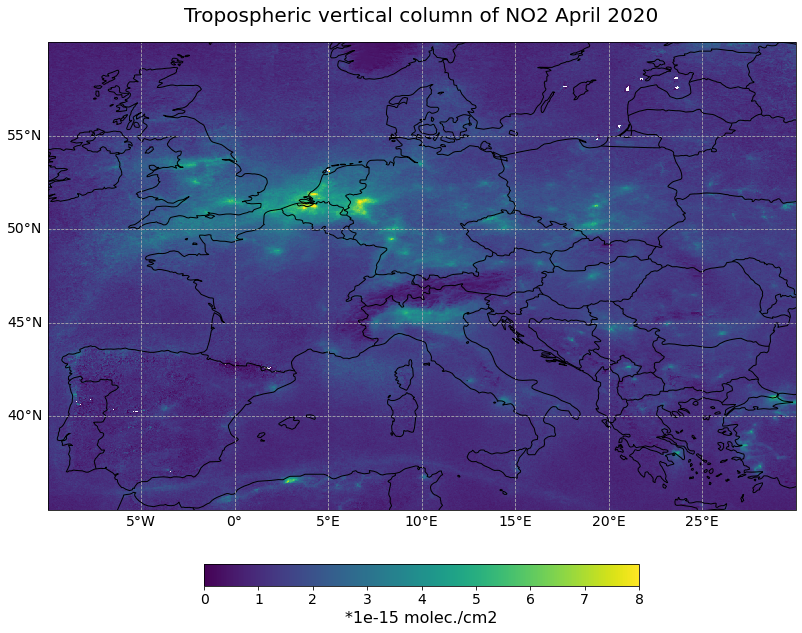

In [17]:
month=5 #Month April
visualize_pcolormesh(data_array=eur20.isel(time=month)*1e-15, 
                     longitude=eur20.longitude, 
                     latitude=eur20.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='viridis', 
                     unit='*1e-15 molec./cm2', 
                     long_name=no2_tropo_2020.long_name + ' April 2020', 
                     vmin=0, 
                     vmax=8, 
                     lonmin=region['lonmin'],
                     lonmax=region['lonmax'],
                     latmin=region['latmin'],
                     latmax=region['latmax'],
                     set_global=False)

## <a id='anomaly'></a>Generate an anomaly map between 2019 and 2020 for a specific month

Let us select a specific month, e.g. April and let us generate an anomaly map between the two years 2019 and 2020. We can simply subtract the `xarray.DataArray` of April 2019 from the `xarray.DataArray` of April 2020.

In [18]:
month = 5 # April
anomaly_1920 = no2_monthly_2020.isel(time=month) - no2_monthly_2019.isel(time=month)
anomaly_1920

<xarray.DataArray 'NO2_tropo' (latitude: 5000, longitude: 10000)>
dask.array<sub, shape=(5000, 10000), dtype=float32, chunksize=(5000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.98 -89.95 -89.91 ... 89.91 89.95 89.98
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

### Select a region and visualize the anomaly map

Let us choose a region, e.g. Europe, and create a geographical subset with the function [generate_geographical_subset](./functions.ipynb#generate_geographical_subset).

In [19]:
region = region_list[0]
eur_anomaly = generate_geographical_subset(xarray=anomaly_1920,
                                           latmin=region['latmin'],
                                           latmax=region['latmax'],
                                           lonmin=region['lonmin'],
                                           lonmax=region['lonmax'])


Use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh) to visualize the anomaly map.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Tropospheric vertical column of nitrogen dioxide (NO2)Anomaly April 2020 to April 2019'}>)

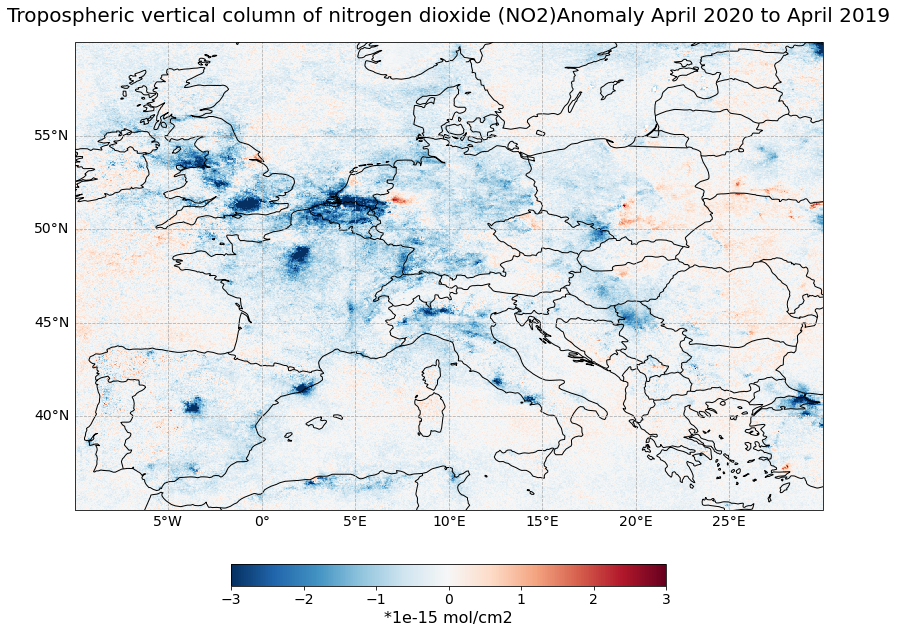

In [20]:
visualize_pcolormesh(data_array=eur_anomaly*1e-15, 
                     longitude=eur_anomaly.longitude, 
                     latitude=eur_anomaly.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='RdBu_r', 
                     unit='*1e-15 mol/cm2', 
                     long_name=no2_tropo_2019.long_name + 'Anomaly April 2020 to April 2019', 
                     vmin=-3, 
                     vmax=3, 
                     lonmin=region['lonmin'],
                     lonmax=region['lonmax'],
                     latmin=region['latmin'],
                     latmax=region['latmax'],
                     set_global=False)

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./352_COVID-19_case_study_GOME-2_time_series.ipynb"><< 352 - Covid-19 case study - GOME-2 time-series analysis</a><span style="float:right;"><a href="./354_COVID-19_case_study_Sentinel-5P_time_series.ipynb">354 - Covid-19 case study - Sentinel-5P time-series analysis >></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>